In [1]:
import glob
import os
import sys

import h5py as h5
import numpy as np
import json

In [4]:
import torch
from sklearn.model_selection import train_test_split

In [31]:
import matplotlib.pyplot as plt

In [2]:
h5_dir = '/om2/scratch/Sat/satra/'
h5_file_paths = sorted(glob.glob(os.path.join(h5_dir, '*.h5')))
h5_pointers = [h5.File(h5_path,'r') for h5_path in h5_file_paths]

In [15]:
slice_nonbrain_dir = '/om2/user/sabeen/feature_sums'
slice_nonbrain_file_paths = sorted(glob.glob(os.path.join(slice_nonbrain_dir, '*feature_sum*.npy')))
all_slice_nonbrain = [np.load(slice_nonbrain_path) for slice_nonbrain_path in slice_nonbrain_file_paths]
all_slice_nonbrain[-1] = np.pad(all_slice_nonbrain[-1], ((0,0),(0,all_slice_nonbrain[0].shape[1] - all_slice_nonbrain[-1].shape[1]),(0,0),(0,0)),mode='constant', constant_values=0)
slice_nonbrain = np.vstack(all_slice_nonbrain) # shape = [10,1150,3,256]
# keep_indices = torch.nonzero(torch.isnan(torch.from_numpy(slice_nonbrain.astype(np.uint8)))) # [num_slices, 4] - (shard_idx, shard_vol_idx, axis, slice_idx)

In [6]:
train_indices, rem_indices = train_test_split(np.arange(0,11479),test_size = 0.2, random_state = 42)
val_indices, test_indices = train_test_split(rem_indices,test_size = 0.5, random_state = 42)
keep_vol_indices = keep_indices[:,0] * 1150 + keep_indices[:,1]
filtered_matrix = keep_indices[np.isin(keep_vol_indices,train_indices)]

In [8]:
train_sums = []
for index in range(filtered_matrix.shape[0]):
    shard_idx, shard_vol_idx, axis, slice_idx = filtered_matrix[index]
    indices = [shard_vol_idx,slice(None),slice(None)]
    indices.insert(axis+1,slice_idx)
    feature_slice = (h5_pointers[shard_idx][f'features_axis{axis}'][tuple(indices)]).astype(np.float32) # (256, 256)
    label_slice = (h5_pointers[shard_idx][f'labels_axis{axis}'][tuple(indices)]).astype(np.int16) # (256, 256)
    feature_slice[label_slice == 0] = 0 # skull stripping?
    train_sums.append(np.sum(feature_slice))

KeyboardInterrupt: 

In [50]:
max(np.unique(slice_nonbrain))

121

In [45]:
bin_size = 50000
bins = np.arange(0, 6050000 + bin_size, bin_size)
hist_counts, bin_edges = np.histogram(slice_nonbrain, bins=bins)
total_count = sum(hist_counts)

print("Histogram Counts:")
for count, bin_edge in zip(hist_counts, bin_edges[:-1]):
    print(f"{bin_edge:.3f}-{bin_edge + bin_size:.3f}: {count} ({count / total_count * 100}%)")

Histogram Counts:
0.000-50000.000: 4044724 (45.79624094202899%)
50000.000-100000.000: 121975 (1.3810575181159421%)
100000.000-150000.000: 113849 (1.2890511775362319%)
150000.000-200000.000: 114870 (1.3006114130434783%)
200000.000-250000.000: 118341 (1.3399116847826087%)
250000.000-300000.000: 122400 (1.3858695652173914%)
300000.000-350000.000: 125121 (1.4166779891304346%)
350000.000-400000.000: 127567 (1.4443727355072464%)
400000.000-450000.000: 128819 (1.4585484601449274%)
450000.000-500000.000: 130002 (1.4719429347826087%)
500000.000-550000.000: 130792 (1.4808876811594203%)
550000.000-600000.000: 131771 (1.4919723731884058%)
600000.000-650000.000: 133235 (1.5085484601449275%)
650000.000-700000.000: 137173 (1.5531363224637682%)
700000.000-750000.000: 142498 (1.6134284420289853%)
750000.000-800000.000: 147328 (1.6681159420289855%)
800000.000-850000.000: 150622 (1.7054121376811595%)
850000.000-900000.000: 155265 (1.7579823369565217%)
900000.000-950000.000: 158991 (1.8001698369565218%)
9

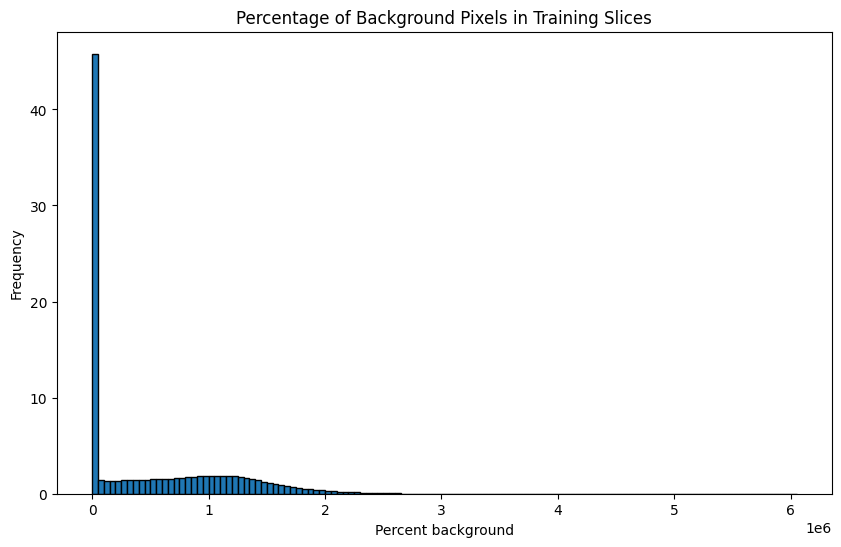

In [46]:
# Plotting the histogram
hist_percentages = [item / total_count * 100 for item in hist_counts]
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_percentages, width=bin_size, align='edge', edgecolor='black')

# Adding labels and title
plt.xlabel('Percent background')
plt.ylabel('Frequency')
plt.title('Percentage of Background Pixels in Training Slices')

# Adding percentage labels on top of each bar
# for count, bin_edge in zip(hist_counts, bin_edges[:-1]):
#     percentage = count / total_count * 100
#     plt.text(bin_edge + bin_size / 2, count, f"{percentage:.2f}%", ha='center', va='bottom')

# plt.grid(True)
plt.show()

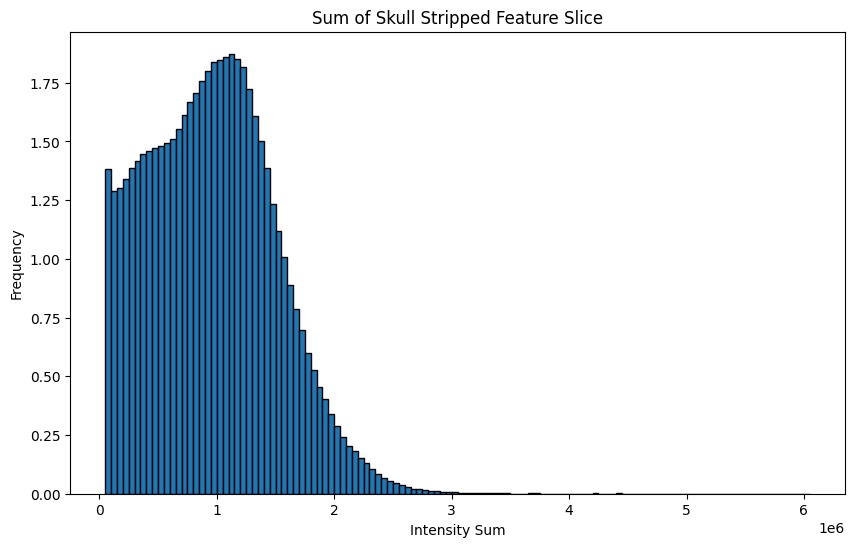

In [47]:
# Plotting the histogram
hist_percentages = [item / total_count * 100 for item in hist_counts]
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[1:-1], hist_percentages[1:], width=bin_size, align='edge', edgecolor='black')

# Adding labels and title
plt.xlabel('Intensity Sum')
plt.ylabel('Frequency')
plt.title('Sum of Skull Stripped Feature Slice')

# Adding percentage labels on top of each bar
# for count, bin_edge in zip(hist_counts, bin_edges[:-1]):
#     percentage = count / total_count * 100
#     plt.text(bin_edge + bin_size / 2, count, f"{percentage:.2f}%", ha='center', va='bottom')

# plt.grid(True)
plt.show()

In [40]:
matth_cutoff = slice_nonbrain < 52428

In [52]:
np.sum(matth_cutoff) / (10 * 1150 * 3 * 256)

0.4586954257246377